# ⌚️ DM&ML 2020 - Team Rolex

## 🖋 Authors
- Francis Ruckstuhl, 16-821-738
- Hanna Birbaum, 16-050-114
- Loïc Rouiller-Monay, 16-832-453

## 🕵️ Project description

Real or Not? NLP with Disaster Tweets: Machine Learning model that can predict which tweets are about a real disaster and which are not. The project topic is based around a Kaggle competition.


## 📝 Commits

### Best commit:

**Commit 2 : 0.818%**
- data cleaning : remove unicode literals, urls, link, author, hashtags, rt
- feature engineering : num_chars, num_words, avg_words
- BOW
- LogisticRegression(solver='lbfgs', max_iter=1000)

### [B.] Previous commits

**Commit 1 : 0.808%**
- spacy_tokenizer: remove stopwords, punctuation, numbers then lemmatize and lowercase
- TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), tokenizer=spacy_tokenizer)
- LogisticRegression(solver='lbfgs', max_iter=1000)

**Commit 2 : 0.818%**
- data cleaning : remove unicode literals, urls, link, author, hashtags, rt
- feature engineering : num_chars, num_words, avg_words
- BOW
- LogisticRegression(solver='lbfgs', max_iter=1000)

**Commit 3 : 0.809%**
- data cleaning : remove unicode literals, urls, link, author, hashtags, rt, punctuations, lowercase
- feature engineering : num_chars, num_words, avg_words, num_hashtags
- BOW
- LogisticRegression(solver='lbfgs', max_iter=1000)

**Commit 4 : 0.801%**
- data cleaning : remove unicde literals, urls, link, author, hashtags, rt, punctuations, lowercase, lemmatize, stemming
- model_dbow = Doc2Vec(dm=0, vector_size=30, negative=6, hs=0, min_count=1, sample=0, workers=cores, epoch=300)
- Word2Vec
- LogisticRegression(max_iter=1000, solver='lbfgs')

**Commit 5 : 0.812%**
- Same as Commit 4 but without stemming

### [C.] Progression of accuracies

<AxesSubplot:xlabel='commit_number', ylabel='accuracy'>

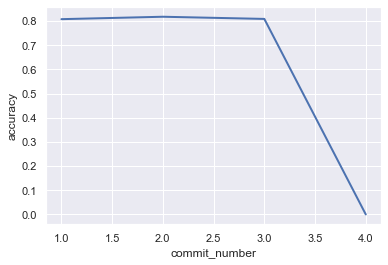

In [46]:
# /!\ You have to run Chapter 1. "libraries“ first before being able to plot the progression of accuracies
accuracy_progression = pd.read_csv('../documents/accuracy_progression.csv', sep=';')
sns.lineplot(x=accuracy_progression.commit_number, y=accuracy_progression.accuracy, linewidth=2)

# 📚 1. Libraries

In [47]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")
import spacy
from nltk.stem.snowball import SnowballStemmer
# load English language model of spacy
sp = spacy.load('en_core_web_sm')
import string
from spellchecker import SpellChecker
import pycountry
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

from gensim.models.doc2vec import TaggedDocument

In [48]:
# Yet to discuss whether this will be used or not
from sklearn.preprocessing import LabelEncoder

# 📂 2. Download data


## Files
- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - a sample submission file in the correct format

In [49]:
train = pd.read_csv('../data/training_data.csv')
test = pd.read_csv('../data/test_data.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

In [50]:
train.head(5)

,id,keyword,location,text,target
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1


## Features
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [51]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6471 entries, 0 to 6470
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        6471 non-null   int64 
 1   keyword   6416 non-null   object
 2   location  4330 non-null   object
 3   text      6471 non-null   object
 4   target    6471 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 252.9+ KB


# 🔬 3. Exploratory Data Analysis

## [A.] What is the baserate of the problem?

In [52]:
base_rate = train.target.value_counts().max()/len(train)
print(f'\nThe base rate is {base_rate}')


The base rate is 0.5719363313243703


## Target class distribution

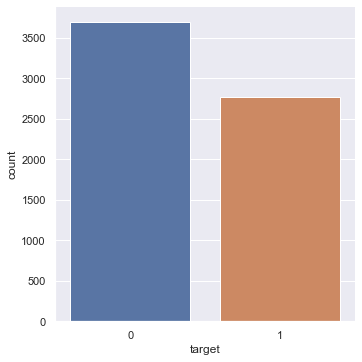

In [53]:
sns.catplot(x="target", kind="count", data=train);

## Missing values

In [54]:
train.isnull().any()

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

It misses value in two features : keyword and location.

### Missing value in "keyword"

In [55]:
train.keyword.isnull().value_counts()

False    6416
True       55
Name: keyword, dtype: int64

### Missing value in "location"

In [56]:
train.location.isnull().value_counts()

False    4330
True     2141
Name: location, dtype: int64

## Tweets length

### Number of characters

In [57]:
train["num_char"] = train["text"].apply(len)
test["num_char"] = test["text"].apply(len)

<AxesSubplot:xlabel='target', ylabel='num_char'>

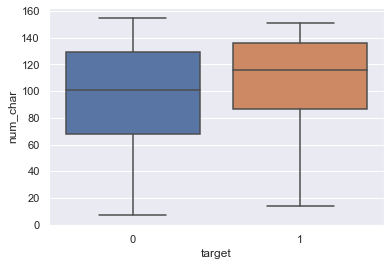

In [58]:
sns.boxplot(x='target', y='num_char', data=train)

##### Findings
Tweets about real disaster seems to be lengthier.

### Number of words

In [59]:
train["num_words"] = train["text"].apply(lambda x: len(x.split()))
test["num_words"] = test["text"].apply(lambda x: len(x.split()))

<AxesSubplot:xlabel='target', ylabel='num_words'>

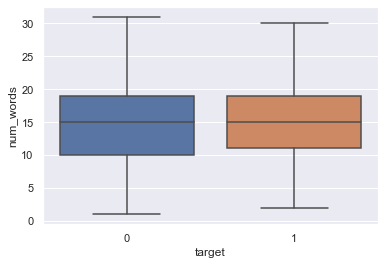

In [60]:
sns.boxplot(x='target', y='num_words', data=train)

##### Findings
Tweets about real disaster do not seem to have more words. Maybe it'll help to take this into consideration.

### Average word length

In [61]:
train["avg_word_length"] = train['text'].apply(lambda x: np.sum([len(w) for w in x.split()]) / len(x.split()))
test["avg_word_length"] = test['text'].apply(lambda x: np.sum([len(w) for w in x.split()]) / len(x.split()))

<AxesSubplot:xlabel='target', ylabel='avg_word_length'>

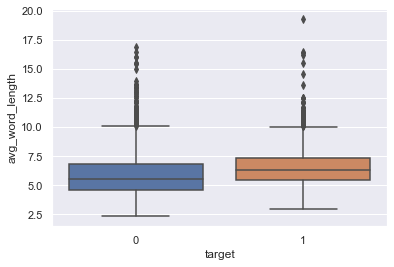

In [62]:
sns.boxplot(x='target', y='avg_word_length', data=train)

##### Findings
Tweets about real disaster seems to have lengtier average word length

### Number of hashtags in text

In [63]:
train['num_hashtags'] = train['text'].apply(lambda x: x.count('#'))

<AxesSubplot:xlabel='target', ylabel='num_hashtags'>

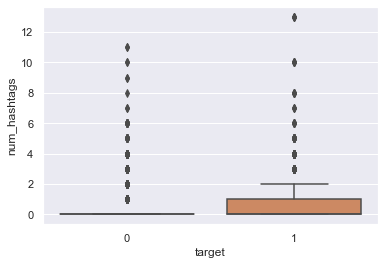

In [64]:
sns.boxplot(x='target', y='num_hashtags', data=train)

### Keywords 

In [65]:
### DISCUSS WITH TEAMMATES ###
# Replace NaN values with "Unknown"? (NaNs need to be replace for label encoding)
train["keyword"] = train["keyword"].fillna("Unknown")

In [66]:
# Label encoding for keywords
label = LabelEncoder()
keyword_label = pd.Series(label.fit_transform(train["keyword"]), name="keyword_code")
keyword_label.head()

0     75
1     17
2    216
3    122
4    128
Name: keyword_code, dtype: int32

In [67]:
# Perhaps display the most frequent keywords? 
train["keyword"].value_counts().head()

Unknown       55
deluge        39
earthquake    38
collision     37
harm          37
Name: keyword, dtype: int64

## Disaster Location

In [68]:
# Where do most disasters occur / where do disaster tweets come from? 
# Potential problem to take care of: USA and United States are separate; Different US States are also separate;

In [69]:
# How many different locations are there?
train["location"].nunique()

2921

In [70]:
# Create regex for countries that require cleaning:

# United States:
usa_regex = re.compile(r"""(?i)Alabama|\bAL\b|Alaska|\bAK\b|Arizona|\bAZ\b|Arkansas|\bAR\b|California|\bCA\b|Colorado|\bCO\b|
                Connecticut|\bCT\b|Delaware|\bDE\b|Florida|\bFL\b|Georgia|\bGA\b|Hawaii|\bHI\b|Idaho|\bID\b|Illinois|\bIL\b|
                Indiana|\bIN\b|Iowa\bIA\b|Kansas|\bKS\b|Kentucky|\bKY\b|Louisiana|\bLA\b|Maine|\bME\b|Maryland|\bMD\b|Massachusetts|
                \bMA\b|Michigan|\bMI\b|Minnesota|\bMN\b|Mississippi|\bMS\b|Missouri|\bMO\b|Montana|\bMT\b|Nebraska|\bNE\b|Nevada|
                \bNV\b|New\sHampshire|\bNH\b|New\sJersey|\bNJ\b|New Mexico|\bNM\b|New\sYork|\bNY\b|\bNYC\b|North\sCarolina|\bNC\b|
                North\sDakota|\bND\b|Ohio|\bOH\b|Oklahoma|\bOK\b|Oregon|\bOR\b|Pennsylvania|\bPA\b|Rhode\sIsland|\bRI\b|South\sCarolina|
                \bSC\b|South\sDakota|\bSD\b|Tennessee|\bTN\b|Texas|\bTX\b|Utah|\bUT\b|Vermont|\bVT\b|Virginia|\bVA\b|Washington|\bWA\b|
                West\sVirginia|\bWV\b|Wisconsin|\bWI\b|Wyoming|\bWY\b|\bUSA\b|San\sFrancisco|Los\sAngeles|Seattle|Chicago|
                Atlanta""", re.VERBOSE)

# United Kingdom:
uk_regex = re.compile(r"""(?i)UK|London|England|Scotland|Wales|Birmingham|Glasgow|Liverpool|Bristol|Manchester|
                      Sheffield|Leeds|Edinburgh|Leicester|Coventry|Bradford|Cardiff|Belfast|Oxford|Plymouth|Aberdeen""", re.VERBOSE)

# Canada:
ca_regex = re.compile(r"""(?i)Canada|Ontario|Quebec|Nova\sScotia|New Brunswick|Manitoba|British\sColumbia|Prince\sEdward\sIsland|
                      Saskatchewan|Alberta|Newfoundland|Labrator|Toronto|Ottawa|Vancouver|Calgary""", re.VERBOSE)

# Australia:
au_regex = re.compile(r"""(?i)australia|Brisbane|Melbourne|Sydney|Perth|Adelaide|Capital\sTerritory|Canberra|Hobart|
                      Darwin|Gold\sCoast|Queensland|Victoria|Tasmania""", re.VERBOSE)

# India:
in_regex = re.compile(r"""(?i)mumbai|Maharashtra|Delhi|Kolkata|West\sBengal|Chennai|Tamil\sNadu|Hyderabad|Bangalore|
                      Ahmedabad|Surat|Jaipur|Kanpur|Nagpur|Gujarat|Uttar\sPradesh""", re.VERBOSE)

In [71]:
# Iterate through the rows and check if any of the locations matches one of our regexes
# If so, the entire value will be replaced by a unified name:

for index, row in train.iterrows():

  # For any location in the United States:
  if re.search(usa_regex, str(train.loc[index, "location"])):
    train.loc[index, "location"] = "United States"

  # For any location in the United Kingdom:
  elif re.search(uk_regex, str(train.loc[index, "location"])):
    train.loc[index, "location"] = "United Kingdom"

  # For any location in Canada:
  elif re.search(ca_regex, str(train.loc[index, "location"])):
    train.loc[index, "location"] = "Canada"
  
  # For any location in Australia:
  elif re.search(au_regex, str(train.loc[index, "location"])):
    train.loc[index, "location"] = "Australia"
  
  # For any location in the India:
  elif re.search(in_regex, str(train.loc[index, "location"])):
    train.loc[index, "location"] = "India"

<AxesSubplot:>

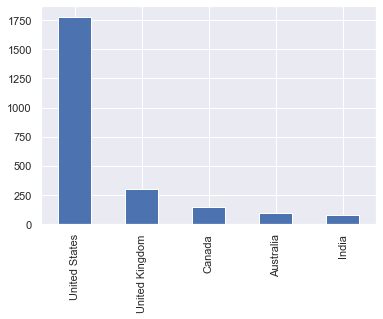

In [72]:
# Plot the top 5 countries:
countries = train["location"].value_counts()
countries = countries.sort_values(ascending=False).head(5)
countries.plot(kind="bar")

In [73]:
### DISCUSS WITH TEAMMATES ###
# Will this help with data cleaning?

# 🧹 4. Data cleaning

## Keywords

In [74]:
# remove '%20' from keyword feature
train.keyword = train.keyword.apply(lambda lex: str(lex).replace('%20', ' '))
test.keyword = train.keyword.apply(lambda ro: str(ro).replace('%20', ' '))

In [75]:
# check if NaN values in the keyword feature
print(train.keyword.isnull().any())
print(test.keyword.isnull().any())

# There's no null values between the keywords

False
False


In [76]:
# use pycountry in order to check if a country appears in the location
# if yes takes the country, else turn it to NaN
# with train and test data set

In [77]:
# train.location.apply(lambda x: print(x))

## Text

In [78]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS
punctuations = string.punctuation

def separate_punct(text):
    temp = []
    for char in text:
        if char not in punctuations:
            temp.append(char)
        else:
            temp.append(' '+char)
    return ''.join(temp)

def clean_text(text):
    # remove unicode literals
    temp = text.encode('ascii',errors='ignore').decode('ascii')
    
    # remove &amp
    temp = temp.replace('&amp;', '')
    
    # remove urls
    temp = re.sub(r"http\S+", "", temp)
    
    # remove html
    temp = re.sub(r'<.*?>', "", temp)
    
    # remove hashtags
    temp = re.sub(r'#', "", temp)

    # remove people account with @
    temp = re.sub(r'@\S+', "", temp)
    
    # remove 'RT'
    temp = temp.replace('RT', '')
    
    # remove punctuation
    temp = ''.join([ char for char in temp if char not in punctuations ])
    
    # separate punctuation
    # temp = separate_punct(temp)

    # remove "."
    #temp.replace('.','')
    
    # lowercase
    temp = temp.lower()
    
    # spell checking
    spell = SpellChecker()
    temp_spellchecked = []
    for word in temp.split():
        temp_spellchecked.append(spell.correction(word))
        
    # stemming with nltk
    #stemmer = SnowballStemmer(language='english')
    #temp_stemmed = []
    #for word in temp_spellchecked:
    #    temp_stemmed.append(stemmer.stem((word)))
    
    # create spacy object
    temp = sp(' '.join(temp_spellchecked))

    # lemmatize each token and convert each token into lowercase
    temp = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in temp ]
    
    # remove stop words 
    temp = [ word for word in temp if word not in stop_words  ]
    
    # join
    temp = ' '.join(temp)
    
    return temp

In [25]:
%%time
# clean text
train.text = train.text.apply(lambda x: clean_text(x))
test.text = test.text.apply(lambda x: clean_text(x))

Wall time: 1h 37min 28s


In [26]:
train.to_csv('train_spellchecked.csv')
test.to_csv('test_spellchecked.csv')


In [36]:
train = pd.read_csv('../data/train_spellchecked.csv')
test = pd.read_csv('../data/test_spellchecked.csv')

In [37]:
train.text.apply(lambda x: print(x))

black eye 9 space battle occur star a74 involve 3 fleet total 3945 ship 17 destroy
world feel long transport bioterror germ wake anthrax lab mishap
reality training train fall elevated track windsor paramedic ems
taiwan grace expect large rock tree mud unstable and/or saturate land slide hazardous hillymountain area
new isis video isis threaten behead croatian hostage 48 hour tlvface tlvfacesauspol
freebesieged martinmj22 yugo tory landslide possibly mean wafer - thin majority g
billionaire plan free half billion dollar trap venezuela year report
old testimony weapon use promote conflict tactic corruption infiltration group
ali fly plane run burn building soup man child booradleyvancullen
thunder shake house wake sister car alarm
police monitor 200 jihad poland
dad panic weight loss mean need hurry new clothe fundwhen reach goal
alleged driver kuwait attack join dash day june 26 suicide bombing confess court
video fire burn apartment building blow car manchester
thanks benson clegg fol

scream
bad day
video pick body water rescuer search migrant mediterraneo
break ibama official muslim terrorist weapon use texas attack
game officially collapse
cyclone derive power calm center person norman vincent peace
s trouble know caaaaaall
hate talk grandma mean love death talk damn ssshhheeesshh
talk got fantastic interesting fact far manually buy ru domains sinkhole seek coop
friday suppose happy day bloody friday hah jazz
geddit update content policy promise quarantine extremely offensive community
hellfire surround desire careful let desire control afterlife islam
feel long transport bioterror germ wake anthrax lab mishap
remember old song hear year word carry flood memory priceless
s man
sure megaquake story bring sense panic question change
update jag enable hijacker access look finger cross
casualty roleplay somebody bored
article michael jackman metro times detroit group later downgrade estimate 37 square mile
cross - border terrorism pakistan catch red - handed time indi

anti collision rear technology cool techesback tech
crack path wipe morning beach run surface wound leave elbow right knee
parent kid burn man 11 year old think
yea bombing pearlharbor good idea
angry mistrustful rescue elephant find peace friendship new home photo
apparently face scream emotionally attach cheat
motorcyclist bicycle injure denver collision broadway
burn question chris mullin st johns 201516 sub
320 ir icemoon aftershock dust trapmusic dnb erm dance ice
wftu eyewitness news tn school psychologist arrest florida child porn charge
fettilootch slanglucci oppression great danger come soon album
abbswinston zionist terrorist kidnap 15 palestinians overnight terror palestinian village
nissannews trauma alert 1 child 6 hospitalize car wreck aha near bring land
drown demon know swim
saved bush lower tax rate wealthy n economy collapse middle class 401ks destroy
drown insult feel devote pride fold action repercussion set birth retroactive
cdc pretty cool list bioterrorism agent 

lava dragon breeder breed lava dragon dragonvale visit park check
crash burn
theory way sense dwarf actual origin blight
gunman kill el salvador bus attack suspect salvadorean gang member kill people wound s
jsunnews storm damage report madison county thunderstorm damage report ar
tax issue hazardous weather outlook
hot antenna hijacking computer send datum sound wave black hat 2015 firebreak good
god cocky right love uribe obliterate ball strut fuck batter box
pm satellite bullseye typhoon soudelor
body bag
bump approval probably s blow musicadvisory
final medina update shoot 105 49 explode 56 imkeepingmydayjob pic famous 17
sing tsunami beginners computer tutorial want learn build pc
praise god ministry tell like youth biblestudy
rank artectura pop2015 n3 florence machine ship wreck music playlist couture
burn
sunday football seasonfrom 9 11 pm woman log shit complete war zone
aaa ok femme room hear gay ass scream
kia ban quarantine month end
soon police dispatch person threaten shoo

0       None
1       None
2       None
3       None
4       None
        ... 
6466    None
6467    None
6468    None
6469    None
6470    None
Name: text, Length: 6471, dtype: object

## Location

In [38]:
train.location.isnull().value_counts()

False    4330
True     2141
Name: location, dtype: int64

# 🛠 [D.] 5. Feature Engineering

In [39]:
pycountry.countries.search_fuzzy('England')

[Country(alpha_2='GB', alpha_3='GBR', name='United Kingdom', numeric='826', official_name='United Kingdom of Great Britain and Northern Ireland')]

In [40]:
# not good 
def location_to_country(location):
    temp = location.split(',')
    countries = list(pycountry.countries)
    
    for word in temp:
        for i in range(len(countries)):
            if (word.strip() in countries[i].alpha_2) or (word.strip() in countries[i].alpha_3) or (word.strip() in countries[i].name):
                return countries[i].name
    return 'Unknown'

train['country'] = train.location.apply(lambda x: location_to_country(str(x)))
train[['location', 'country']].head(20)

,location,country
0,USA,United States
1,NaN,Unknown
2,"Palm Beach County, FL",Falkland Islands (Malvinas)
3,USA,United States
4,Australia,Australia
5,Scotland,Unknown
6,New York City,Unknown
7,Multinational *****,Unknown
8,Los Angeles,Unknown
9,NaN,Unknown


# ⚙️ 6. Preprocessing

In [79]:
# Create tokenizer function for preprocessing
def spacy_tokenizer(text):

    # Define stopwords, punctuation, rolex and numbers
    stop_words = spacy.lang.en.stop_words.STOP_WORDS
    punctuations = string.punctuation
    # numbers = "0123456789"

    # Create spacy object
    mytokens = sp(text)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    
    # Remove all word with less that 3 letters (remove noise)
    mytokens = [ word for word in mytokens if len(word)>2 ]

    # Return preprocessed list of tokens
    return mytokens

In [29]:
# Tokenize texts
processed_texts = []
for text in train.text:
    processed_text = spacy_tokenizer(text)
    processed_texts.append(processed_text)

# 🤖 7. Models

## BOW with Logistic Regression

In [163]:
# Using default tokenizer 
count = CountVectorizer(ngram_range=(1,2), stop_words="english")
bow = count.fit_transform(train.text)

In [164]:
# Get feature names
feature_names = count.get_feature_names()

In [165]:
# Show as a dataframe
processed_train = pd.DataFrame(
    bow.todense(), 
    columns=feature_names
    )

In [166]:
# Select features
X = processed_train # the features we want to analyze
y = train['target'] # the labels, or answers, we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [36]:
# Define classifier
classifier = LogisticRegressionCV(solver='lbfgs', max_iter=1000, cv=3)

In [38]:
# Fit model on training set
classifier.fit(X_train, y_train)

LogisticRegressionCV(cv=3, max_iter=1000)

In [39]:
# Predictions
y_pred = classifier.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7938


#### BOW with more additional features

In [167]:
train_full = pd.concat([train[['num_char', 'num_words', 'avg_word_length', 'num_hashtags']], processed_train], axis=1)

In [168]:
# Select features
X = processed_train # the features we want to analyze
y = train['target'] # the labels, or answers, we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [169]:
# Define classifier
classifier = LogisticRegressionCV(solver='lbfgs', max_iter=3000, cv=3)

In [170]:
%%time
# Fit model on training set
classifier.fit(X_train, y_train)

Wall time: 7min 42s


LogisticRegressionCV(cv=3, max_iter=3000)

In [171]:
# Predictions
y_pred = classifier.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7954


#### BOW with additional features and Decision tree

In [ ]:
train_full = pd.concat([train[['num_char', 'num_words', 'avg_word_length']], processed_train], axis=1)

In [ ]:
# Select features
X = processed_train # the features we want to analyze
y = train['target'] # the labels, or answers, we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [149]:
# Define classifier
classifier = DecisionTreeClassifier()

In [150]:
# Fit model on training set
classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [151]:
# Predictions
y_pred = classifier.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7459


## TF-IDF with Logistic Regression

In [69]:
# Select features
X = train['text'] # the features we want to analyze
y = train['target'] # the labels, or answers, we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [82]:
%%time
# Define vectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 1), tokenizer=spacy_tokenizer)

# Define classifier
classifier = LogisticRegressionCV(solver='lbfgs', max_iter=1000, cv=5)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

/Users/loic/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/loic/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

CPU times: user 1min 22s, sys: 1.82 s, total: 1min 24s
Wall time: 1min 37s


/Users/loic/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(min_df=5, sublinear_tf=True,
                                 tokenizer=<function spacy_tokenizer at 0x7fa8afbc5430>)),
                ('classifier', LogisticRegressionCV(cv=5, max_iter=1000))])

In [83]:
# Predictions
y_pred = pipe.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7776


### Perhaps a random forest? 

In [ ]:
# Maybe try a Random Forest? (- Hanna)
from sklearn.ensemble import RandomForestClassifier

# Define vectorizer
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer) 

# Define classifier
classifier = RandomForestClassifier()

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

# Predictions
y_pred = pipe.predict(X_test)

## Decision tree

In [73]:
%%time
# Define vectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 2), tokenizer=spacy_tokenizer)

# Define classifier
classifier = DecisionTreeClassifier()

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

CPU times: user 1min 14s, sys: 1.74 s, total: 1min 16s
Wall time: 1min 41s


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function spacy_tokenizer at 0x7fa8afbc5430>)),
                ('classifier', DecisionTreeClassifier())])

In [74]:
# Predictions
y_pred = pipe.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7205


## Classification using Doc2Vec and Logistic Regression

In [131]:
sample_tagged = train.apply(lambda r: TaggedDocument(words=spacy_tokenizer(r['text']), tags=[r.target]), axis=1)

KeyboardInterrupt: 

In [ ]:
# Train test split - same split as before
train_tagged, test_tagged = train_test_split(sample_tagged, test_size=0.2, random_state=1234)

In [ ]:
# Allows to speed up a bit
import multiprocessing
cores = multiprocessing.cpu_count()

In [ ]:
# Define Doc2Vec and build vocabulary
from gensim.models import Doc2Vec

model_dbow = Doc2Vec(dm=1, vector_size=100, negative=5, hs=0, min_count=1, sample=0, workers=cores, epoch=500)
model_dbow.build_vocab([x for x in train_tagged.values])

In [ ]:
# Train distributed Bag of Word model
model_dbow.train(train_tagged, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

In [50]:
# Select X and y
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=300)) for doc in sents])
    return targets, regressors

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

# Each document (i.e. complaint) is now a vector in the space of 30 dimentions.
# Similar complaints should have similar vector representation.

In [51]:
# Fit model on training set - same algorithm as before
logreg = LogisticRegressionCV(max_iter=3000, cv=3, solver='lbfgs')
logreg.fit(X_train, y_train)

LogisticRegressionCV(cv=3, max_iter=3000)

In [52]:
# Predictions
y_pred = logreg.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7876


## Classification using Doc2Vec, more features and Logistic Regression

# 🏆 8. Submission

## BOW

In [19]:
# Using default tokenizer 
count = CountVectorizer(ngram_range=(1,2), stop_words="english")
bow = count.fit(train.text)
bow = count.transform(train.text)

In [20]:
# Get feature names
feature_names = count.get_feature_names()

In [21]:
# Show as a dataframe
processed_train = pd.DataFrame(
    bow.todense(), 
    columns=feature_names
    )

In [22]:
train_full = pd.concat([train[['num_char', 'num_words', 'avg_word_length', 'num_hashtags']], processed_train], axis=1)

In [23]:
# Select features
X = train_full # the features we want to analyze
y = train['target'] # the labels, or answers, we want to test against

In [24]:
# Define classifier
classifier = LogisticRegressionCV(solver='lbfgs', max_iter=6000, cv=3)

In [25]:
%%time
# Fit model on training set
classifier.fit(X, y)

Wall time: 1h 38min 30s


LogisticRegressionCV(cv=3, max_iter=6000)

In [26]:
bow_test = count.transform(test.text)
# Get feature names
feature_names_test = count.get_feature_names()

In [27]:
# Show as a dataframe
processed_test = pd.DataFrame(
    bow_test.todense(),
    columns=feature_names_test
    )

In [28]:
test_full = pd.concat([test[['num_char', 'num_words', 'avg_word_length' , 'num_hashtags']], processed_test], axis=1)

KeyError: "['num_hashtags'] not in index"

In [ ]:
# Predictions

y_pred = classifier.predict(test_full)

## TF IDF

In [28]:
# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

In [29]:
pipe.fit(train.text, train.target)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(encoding='latin-1', min_df=5,
                                 ngram_range=(1, 2), sublinear_tf=True,
                                 tokenizer=<function spacy_tokenizer at 0x000001A08775D040>)),
                ('classifier', LogisticRegression(max_iter=1000))])

In [30]:
preds = pipe.predict(test.text)

In [31]:
preds

array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

# Word2Vec

In [44]:
train = pd.read_csv('../data/train_spellchecked.csv')
test = pd.read_csv('../data/test_spellchecked.csv')

In [80]:
train_tagged = train.apply(lambda r: TaggedDocument(words=spacy_tokenizer(r['text']), tags=[r.target]), axis=1)

In [81]:
test['target'] = ''
test

,id,keyword,location,text,num_char,num_words,avg_word_length,target
0,9972,destroyed,NaN,Crptotech tsunami and banks.\r\n http://t.co/K...,90,9,8.888889,
1,9865,bioterror,"Portsmouth, UK",I'm that traumatised that I can't even spell p...,72,12,5.083333,
2,1937,windstorm,NaN,@foxnewsvideo @AIIAmericanGirI @ANHQDC So ... ...,127,16,6.937500,
3,3560,hazardous,NaN,Me watching Law &amp; Order (IB: @sauldale305)...,96,11,7.818182,
4,2731,hostage,bahstun/porta reeko,Papi absolutely crushed that ball,33,5,5.800000,
...,...,...,...,...,...,...,...,...
1137,3497,screams,NaN,@ItsQueenBaby I'm at work it's a bunch of ppl ...,82,15,4.533333,
1138,9191,arson,NaN,#?? #?? #??? #??? Suicide bomber kills 15 in S...,105,16,5.562500,
1139,10217,collided,NaN,Eruption of Indonesian volcano sparks transpor...,129,18,6.222222,
1140,5308,army,New York,Never let fear get in the way of achieving you...,140,17,7.294118,


In [82]:
test_tagged = test.apply(lambda r: TaggedDocument(words=spacy_tokenizer(r['text']), tags=[r.target]), axis=1)

In [83]:
test_tagged

0       ([crptotech, tsunami, bank, http://t.co/khztev...
1       ([traumatise, spell, properly, excuse, typo], [])
2       ([@foxnewsvideo, @aiiamericangiri, @anhqdc, .....
3       ([watch, law, amp, order, @sauldale305, vine, ...
4                   ([papi, absolutely, crush, ball], [])
                              ...                        
1137    ([@itsqueenbaby, work, bunch, ppl, bus, train,...
1138    ([suicide, bomber, kill, saudi, security, site...
1139    ([eruption, indonesian, volcano, spark, transp...
1140    ([let, fear, way, achieve, dream, deltachildre...
1141    ([wowo--===, 12000, nigerian, refugee, repatri...
Length: 1142, dtype: object

In [84]:
# Allows to speed up a bit
import multiprocessing
cores = multiprocessing.cpu_count()

In [85]:
# Define Doc2Vec and build vocabulary
from gensim.models import Doc2Vec

model_dbow = Doc2Vec(dm=0, vector_size=30, negative=6, hs=0, min_count=1, sample=0, workers=cores, epoch=300)
model_dbow.build_vocab([x for x in train_tagged.values])

In [86]:
# Train distributed Bag of Word model
model_dbow.train(train_tagged, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

In [87]:
# Select X and y
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=300)) for doc in sents])
    return targets, regressors

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [88]:
logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
logreg.fit(X_train, y_train)

# Predictions
y_pred = logreg.predict(X_test)

## Export submission

In [89]:
sample_submission.target = y_pred

In [90]:
sample_submission

,target
0,0
1,0
2,1
3,0
4,0
...,...
1137,1
1138,1
1139,1
1140,0


In [91]:
sample_submission.to_csv('submission-005.csv', index=False)